# Gaussian process fit to the transit+granulation

First load all the transit light curves: 

/Users/bmmorris/anaconda/lib/python3.5/site-packages/glymur/config.py:171: UserWarning: Neither the openjp2 nor the openjpeg library could be loaded.  
  warnings.warn(msg)


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

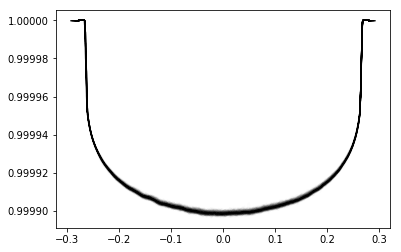

In [1]:
%matplotlib inline
import astropy.units as u
from astropy.constants import R_earth, R_sun
from sunpy.map import Map
from stash import simulate_lightcurve
import matplotlib.pyplot as plt
from astropy.io import fits
from glob import glob
from tqdm import tqdm

paths = glob('decon/*.fits')

# Set up planet parameters
orbital_period = 365 * u.day
semimajor_axis = 1 * u.AU
impact_parameter = 0.0
R_planet = R_earth
R_star = R_sun
lightcurves = []

for path in paths[3:]:
    f = fits.open(path, memmap=False, lazy_load_hdus=True)
    f[1].verify('silentfix')

    # Simulate a light curve for that system, return a `LightCurve` object
    lc = simulate_lightcurve(f[1].data, orbital_period, semimajor_axis,
                             impact_parameter, R_planet, R_star)#, supersample_factor=4)

    if lc.times.min() < -0.4: 
        pass

    else: 
        # Plot the resulting light curve
        lc.plot(alpha=0.01, color='k')
        lightcurves.append(lc)

plt.gca().ticklabel_format(useOffset=False)
# Show me the plot!
plt.show()

Set up the transit parameters 

In [13]:
from batman import TransitParams
import numpy as np

params = TransitParams()
params.per = 365
params.rp = float(R_earth/R_sun)
params.a = float(1*u.AU/R_sun)
params.inc = 89.9

# Sing 2009: https://arxiv.org/pdf/0912.2274.pdf
params.u = [0.6283, -0.3063, 0.8965, -0.4593] #[0.45, 0.0, 0.19, 0.0]
# params.u = [0.45, 0.19]
# params.limb_dark = "quadratic"
params.limb_dark = "nonlinear"

params.ecc = 0
params.w = np.pi/2
params.t0 = 0

Use `celerite` to define a custom kernel of the form

$$ k(\tau) = a e^{-c \tau} \cos\left(\frac{2\pi}{P}\right) $$

and fit simultaneously for the kernel hyperparameters and the transit parameters. 

In [269]:
import emcee
import batman 
from copy import deepcopy
import celerite
from celerite import terms
from celerite.modeling import Model

class CustomTerm(terms.Term):
    """Decaying exponential"""
    parameter_names = ("log_a", "log_c", "log_P")

    def get_complex_coefficients(self, params):
        log_a, log_c, log_P = params
        return (
            np.exp(log_a), 0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )

class MeanModel(Model):
    parameter_names = 'rp, inc, t0, u1, u2'.split(', ')

    def get_value(self, t):
        trial_params = deepcopy(params)
        trial_params.rp = self.rp
        trial_params.inc = self.inc
        trial_params.t0 = self.t0
        trial_params.u = [self.u1, self.u2]

        m = batman.TransitModel(trial_params, t)
        return m.light_curve(trial_params)


cropped_residuals = np.load('cropped_residuals.npy')
correction = np.median(cropped_residuals, axis=0)

bounds = dict(log_a=(-50, 15), log_c=(-10, 10), log_P=(np.log(lc.times[1]-lc.times[0]), 0))
kernel = CustomTerm(log_a=-1, log_c=0, log_P=-5, bounds=bounds)

mean_model = mean=MeanModel(rp=params.rp, t0=params.t0, inc=params.inc,
                            u1=params.u[0], u2=params.u[1],  
                            bounds=dict(rp=(0, 1.2*float(R_earth/R_sun)), t0=(-0.01, 0.01), 
                                        u1=(-1, 1), u2=(-1, 1), inc=(0, 90)))

for lc in lightcurves[0:1]: 

    gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
    gp.compute(lc.times, yerr=0.1e-6)
    
    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(lc.fluxes - correction) + lp

    nwalkers, ndim = 20, 8

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)
    
    initp = [np.array([-20, 4.5, -5, params.rp, params.inc, params.t0, params.u[0], params.u[1]])#, params.u[2], params.u[3]])
             + 1e-5 * np.random.randn(ndim) for _ in range(nwalkers)]

    print('burn in...')
    p0 = sampler.run_mcmc(initp, 20000)[0]
    sampler.reset()
    print('production...')
    sampler.run_mcmc(p0, 5000)

burn in...


/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


production...


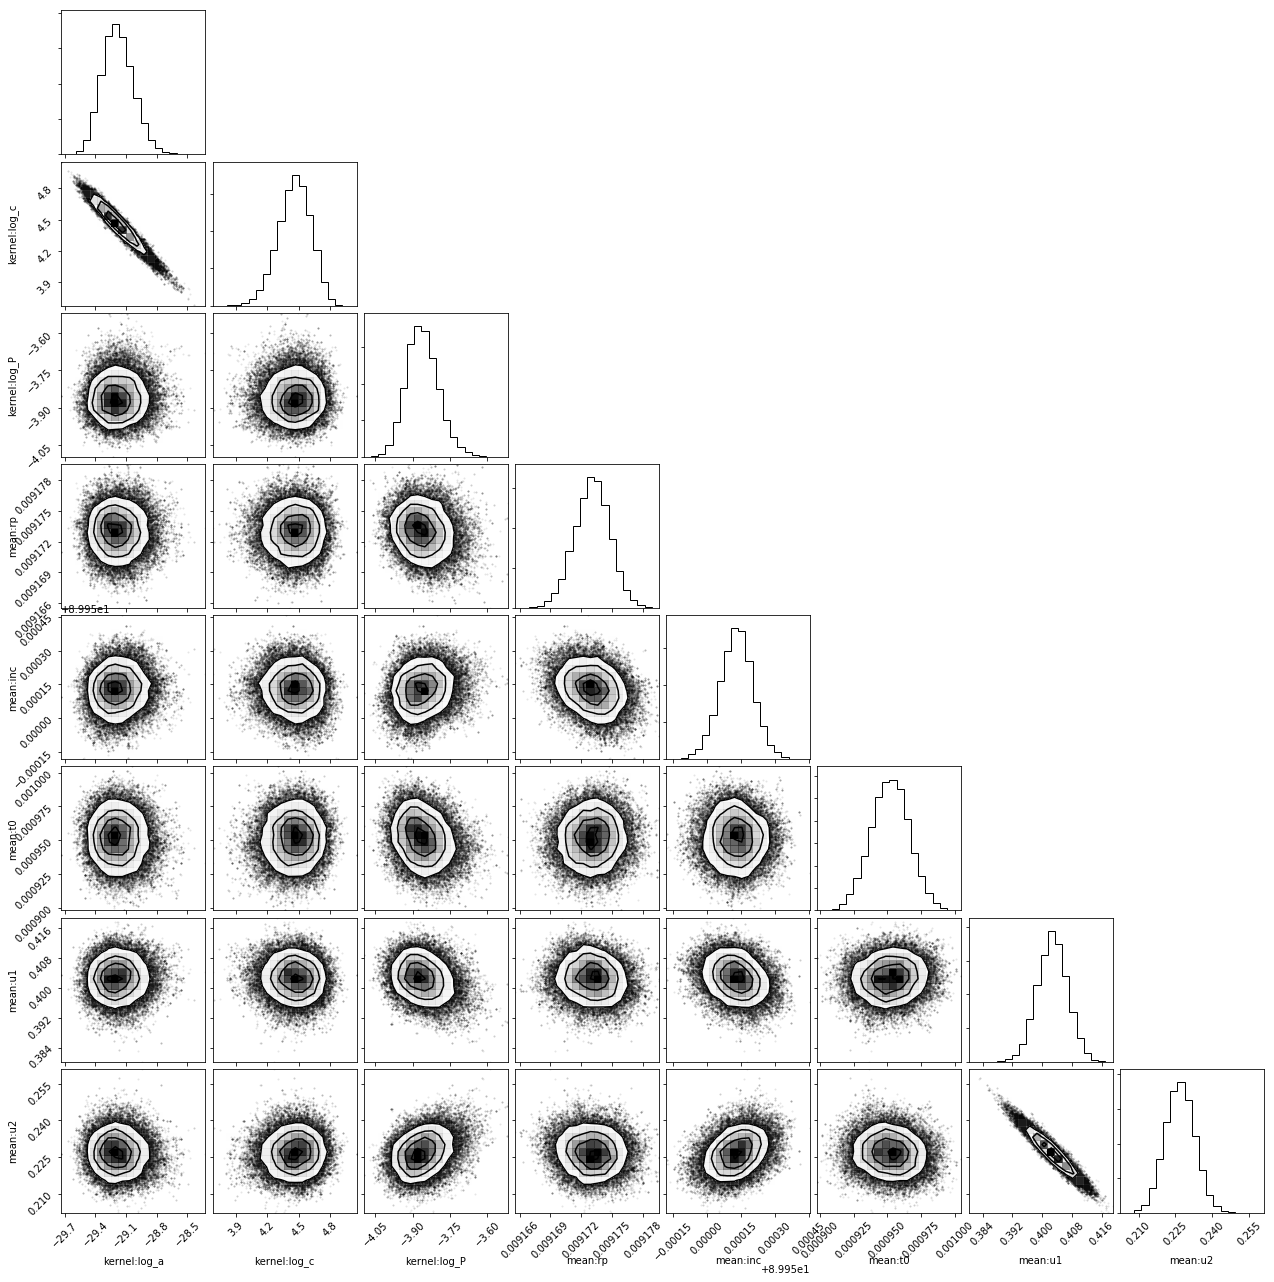

In [271]:
from corner import corner

corner(sampler.flatchain, labels=gp.get_parameter_names());
plt.show()

In [272]:
float(R_earth/R_sun)

0.009167888457668536

In [273]:
np.abs(sampler.flatchain[:, 3].mean() - float(R_earth/R_sun)) /sampler.flatchain[:, 3].std()

2.996476655348427

What is the fractional uncertainty on the exoplanet radius?

In [275]:
sampler.flatchain[:, 3].std()/sampler.flatchain[:, 3].mean()

0.0001878116081723717

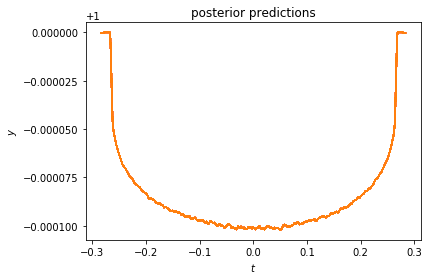

In [217]:
# Plot the data.
x, y = lc.times, lc.fluxes
yerr = 1e-6
t = lc.times
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, zorder=-100)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=200)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color=color, alpha=0.03)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");
# plt.ylim([1-0.00001, 1-0.0002])

In [1]:
#corrected_residuals = np.load('corrected_residuals.npy')